### Import Librabries

In [102]:
# import required package for data handling
import pandas as pd
import numpy as np

# import required packages for splitting data
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# import required packages for evaluating models
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# import `logistic regression` model
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt

### Load the source data

In [103]:
# Create dataframe and fill missing values
df = pd.read_csv('Competition1_raw_data.csv', header=0, na_values=['-'])
df.head(5)
df.dtypes

I1          object
I2          object
I3          object
P(IPO)     float64
P(H)       float64
P(L)       float64
P(1Day)    float64
C1         float64
C2         float64
C3         float64
C4         float64
C5         float64
C6         float64
C7         float64
T1         float64
T2         float64
T3         float64
T4         float64
T5         float64
S1         float64
S2         float64
S3         float64
dtype: object

### Analyze the Source Data

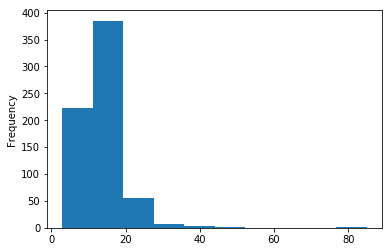

In [104]:
df['P(IPO)'].plot.hist()

In [105]:
# Calculating the number of nulls in each column.
df.isnull().sum()

I1          0
I2          0
I3          8
P(IPO)      5
P(H)       10
P(L)       10
P(1Day)    22
C1         22
C2         22
C3         36
C4         22
C5          6
C6          6
C7         72
T1          1
T2          1
T3          1
T4          1
T5          1
S1          1
S2          1
S3          1
dtype: int64

In [106]:
# Add Positive EPS dummy column C3_D with dummy variable set to 1 if C3 is positive, otherwise 0. 
df['C3_D'] = pd.get_dummies(df.C3 > 0, drop_first=True, dtype=bool)

# Add Share Overhang column C5_D.
df['C5_D']=df['C5']/df['C6']

# Add Up Revision column C6_D.
df['P(mid)'] = ((df['P(H)']+df['P(L)'])/2)
df['C6_D'] = ((df['P(IPO)']-df['P(mid)'])/df['P(mid)']*0.01).where((df['P(IPO)'] > df['P(mid)']), 0)

In [107]:
# Create column T1_D with Percent of long sentences
df['T1_D']=df['T4']/df['T1']
# Create column T3_D with Percent of real words
df['T3_D']=df['T3']/df['T2']
# Create column T5_D with Percent of long words
df['T5_D']=df['T5']/df['T2']
# Create column S1_D with Percent of Positive words
df['S1_D']=df['S1']/df['T2']
# Create column S2_D with Percent of real words
df['S2_D']=df['S2']/df['T2']
# Create column S3_D with Percent of real words
df['S3_D']=df['S3']/df['T2']

#### Adding Target Variables

In [108]:
# Add Pre-IPO Price Revision column Y1.
df['Y1'] = np.where(df['P(IPO)'] < ((df['P(H)'] + df['P(L)'])/2), '1', '0')
df['Y1'] = df['Y1'].astype('int')

#Add Post-IPO Initial Return column Y2.
df['Y2'] = np.where(df['P(IPO)'] < df['P(1Day)'], '1', '0')
df['Y2'] = df['Y2'].astype('int')

df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 34 columns):
I1         682 non-null object
I2         682 non-null object
I3         674 non-null object
P(IPO)     677 non-null float64
P(H)       672 non-null float64
P(L)       672 non-null float64
P(1Day)    660 non-null float64
C1         660 non-null float64
C2         660 non-null float64
C3         646 non-null float64
C4         660 non-null float64
C5         676 non-null float64
C6         676 non-null float64
C7         610 non-null float64
T1         681 non-null float64
T2         681 non-null float64
T3         681 non-null float64
T4         681 non-null float64
T5         681 non-null float64
S1         681 non-null float64
S2         681 non-null float64
S3         681 non-null float64
C3_D       682 non-null bool
C5_D       676 non-null float64
P(mid)     672 non-null float64
C6_D       682 non-null float64
T1_D       681 non-null float64
T3_D       681 non-null float64
T5_D 

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,...,P(mid),C6_D,T1_D,T3_D,T5_D,S1_D,S2_D,S3_D,Y1,Y2
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674,10.0,9.5,8.5,11.870000,122.0,1.0,3.43,...,9.0,0.001111,0.640426,0.908876,0.054250,0.004875,0.009199,0.010929,0,1
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834,8.0,10.0,8.0,7.250000,259.0,0.0,-1.62,...,9.0,0.000000,0.644753,0.898724,0.051395,0.003258,0.011105,0.010876,1,0
2,ACAD,ACADIA PHARMACEUTICALS INC,2834,7.0,14.0,12.0,6.700000,90.0,1.0,-1.24,...,13.0,0.000000,0.636816,0.909350,0.061764,0.011593,0.006271,0.011403,1,0
3,ACHN,ACHILLION PHARMACEUTICALS INC,2834,11.5,16.0,14.0,12.390000,209.0,1.0,-0.91,...,15.0,0.000000,0.539634,0.917060,0.061630,0.009686,0.007144,0.013319,1,1
4,ACLI,AMERICAN COMMERCIAL LINES INC.,4492,21.0,21.0,19.0,56.599998,80.0,1.0,0.07,...,20.0,0.000500,0.587413,0.888469,0.048550,0.004518,0.010047,0.011261,0,1


In [109]:
# Change the data types 
df['Y1'] = df['Y1'].astype('bool')
df['Y2'] = df['Y2'].astype('bool')
df['C2'] = df['C2'].astype('bool')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 34 columns):
I1         682 non-null object
I2         682 non-null object
I3         674 non-null object
P(IPO)     677 non-null float64
P(H)       672 non-null float64
P(L)       672 non-null float64
P(1Day)    660 non-null float64
C1         660 non-null float64
C2         682 non-null bool
C3         646 non-null float64
C4         660 non-null float64
C5         676 non-null float64
C6         676 non-null float64
C7         610 non-null float64
T1         681 non-null float64
T2         681 non-null float64
T3         681 non-null float64
T4         681 non-null float64
T5         681 non-null float64
S1         681 non-null float64
S2         681 non-null float64
S3         681 non-null float64
C3_D       682 non-null bool
C5_D       676 non-null float64
P(mid)     672 non-null float64
C6_D       682 non-null float64
T1_D       681 non-null float64
T3_D       681 non-null float64
T5_D    

In [110]:
# Drop columns and view head
df.drop(['P(IPO)', 'P(H)', 'P(L)', 'P(1Day)', 'P(mid)', 'C3', 'C5', 'C6', 'T1', 'T2', 'T3', 'T4', 'T5', 'S1', 'S2', 'S3'], axis=1, inplace=True)
df.head()

,I1,I2,I3,C1,C2,C4,C7,C3_D,C5_D,C6_D,T1_D,T3_D,T5_D,S1_D,S2_D,S3_D,Y1,Y2
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674,122.0,True,0.029074,51.345,True,3.864345,0.001111,0.640426,0.908876,0.054250,0.004875,0.009199,0.010929,False,True
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834,259.0,False,-0.013352,25.936,False,12.028832,0.000000,0.644753,0.898724,0.051395,0.003258,0.011105,0.010876,True,False
2,ACAD,ACADIA PHARMACEUTICALS INC,2834,90.0,True,0.020715,7.378,False,3.369134,0.000000,0.636816,0.909350,0.061764,0.011593,0.006271,0.011403,True,False
3,ACHN,ACHILLION PHARMACEUTICALS INC,2834,209.0,True,0.020023,8.526,False,3.299697,0.000000,0.539634,0.917060,0.061630,0.009686,0.007144,0.013319,True,True
4,ACLI,AMERICAN COMMERCIAL LINES INC.,4492,80.0,True,-0.034895,632.298,True,3.726269,0.000500,0.587413,0.888469,0.048550,0.004518,0.010047,0.011261,False,True


Check the shape of the data.

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 18 columns):
I1      682 non-null object
I2      682 non-null object
I3      674 non-null object
C1      660 non-null float64
C2      682 non-null bool
C4      660 non-null float64
C7      610 non-null float64
C3_D    682 non-null bool
C5_D    676 non-null float64
C6_D    682 non-null float64
T1_D    681 non-null float64
T3_D    681 non-null float64
T5_D    681 non-null float64
S1_D    681 non-null float64
S2_D    681 non-null float64
S3_D    681 non-null float64
Y1      682 non-null bool
Y2      682 non-null bool
dtypes: bool(4), float64(11), object(3)
memory usage: 77.3+ KB


#### Imputation

In [112]:
# Replace the missing data with mean/median/mode
df['C1'].fillna(df['C1'].median(), inplace = True)
df['I3'].fillna(df['I3'].mode(), inplace = True)
df['C2'].fillna(df['C2'].median(), inplace = True)
df['C4'].fillna(df['C4'].median(), inplace = True)
df['C7'].fillna(df['C7'].median(), inplace = True)
df['C5_D'].fillna(df['C5_D'].median(), inplace = True)
df['T1_D'].fillna(df['T1_D'].median(), inplace = True)
df['T3_D'].fillna(df['T3_D'].median(), inplace = True)
df['T5_D'].fillna(df['T5_D'].median(), inplace = True)
df['S1_D'].fillna(df['S1_D'].median(), inplace = True)
df['S2_D'].fillna(df['S2_D'].median(), inplace = True)
df['S3_D'].fillna(df['S3_D'].median(), inplace = True)
df.isnull().sum()

I1      0
I2      0
I3      8
C1      0
C2      0
C4      0
C7      0
C3_D    0
C5_D    0
C6_D    0
T1_D    0
T3_D    0
T5_D    0
S1_D    0
S2_D    0
S3_D    0
Y1      0
Y2      0
dtype: int64

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 18 columns):
I1      682 non-null object
I2      682 non-null object
I3      674 non-null object
C1      682 non-null float64
C2      682 non-null bool
C4      682 non-null float64
C7      682 non-null float64
C3_D    682 non-null bool
C5_D    682 non-null float64
C6_D    682 non-null float64
T1_D    682 non-null float64
T3_D    682 non-null float64
T5_D    682 non-null float64
S1_D    682 non-null float64
S2_D    682 non-null float64
S3_D    682 non-null float64
Y1      682 non-null bool
Y2      682 non-null bool
dtypes: bool(4), float64(11), object(3)
memory usage: 77.3+ KB


In [114]:
#df_I3 = df['I3'].value_counts()
#df.groupby('I3').sum()
#df['I3'].str.replace(r'\,','0').astype(float)
#df_I3 = df.groupby(['I3'])['I3'].agg({'Frequency':'count'})
#df_I3

In [117]:
df['I3'].fillna(0)
df_I3 = df.I3
df_I3.head()
df_I3 = df_I3.astype('str')
# check the value in column contains ',', if so then replace the whole value as '0'
df[df_I3.str.contains(",")] = '0'
df[df_I3.str.contains(" ")] = '0'
# You should change the dtype back to 'float' or 'int' to match the original data
# if the original dtype is object then do NOT do this!!!
#df_I3 = df_I3.astype('float')
# look at the first 5 values to see if they are changed
df_I3.head()

0    3674
1    2834
2    2834
3    2834
4    4492
Name: I3, dtype: object

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 18 columns):
I1      682 non-null object
I2      682 non-null object
I3      674 non-null object
C1      682 non-null float64
C2      682 non-null bool
C4      682 non-null float64
C7      682 non-null float64
C3_D    682 non-null bool
C5_D    682 non-null float64
C6_D    682 non-null float64
T1_D    682 non-null float64
T3_D    682 non-null float64
T5_D    682 non-null float64
S1_D    682 non-null float64
S2_D    682 non-null float64
S3_D    682 non-null float64
Y1      682 non-null bool
Y2      682 non-null bool
dtypes: bool(4), float64(11), object(3)
memory usage: 77.3+ KB


In [49]:
def assign_label(df_I3):
    if df_I3 > 100 and df_I3 < 4000:
        return 1
    elif df_I3 >= 4000 and df_I3 < 6000:
        return 2
    elif df_I3 >= 6000 and df_I3 < 10000:
        return 3
    else:
        return 4
    
df['I3'] = df['I3'].apply(assign_label)    
dummy_df = pd.get_dummies(df['I3'], prefix='Class')
df = pd.concat([df, dummy_df], axis=1)

df.head()

TypeError: '>' not supported between instances of 'str' and 'int'

In [ ]:
from sklearn_pandas import CategoricalImputer
imputer=CategoricalImputer(strategy='most_frequent', axis=1)
imputer.fit(df[["I3"]])
imputer.transform(df)  